#### What we were doing last time

We need to run experiment p = 0.7
Don't bother plotting fmaps, it's useless to us.
Set up their text cells as we gain knowledge about their behaviour.

In training logs, we see that at most times, val accuracy is higher, and loss is lower than that of training, we could use that in our markdown files as an observation near the generalization error plot, it indicates the effects of regularization.

# Dropout in Fully Connected Layers

## Purpose
We test whether applying dropout to the **fully connected layers** reduces overfitting and improves generalization.  
This notebook compares FC dropout performance against the baseline.  

In [ ]:
!pip install thop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/regularization-ml/


/content/drive/MyDrive/regularization-ml


In [4]:
import torch
from PIL import Image

from config.paths import PathConfig # Path config

from src.model import MiniCNN, ConvBlock, FCBlock
from src.train import trainModel
from src.data import CustomDataset, load_cifar_10_data, check_data_loading, Loader, class_to_idx
from src.visualizations import plotFmaps_and_activationHist, plotCurves
from src.utils import EarlyStopping, unpickle, loadWeights, readJson, genError, saveHistory, evalModel

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
paths = PathConfig("regularization-ml", "regularization-data")
PROJECT_DIR = paths.project
DATA_DIR = paths.data
BASE_DIR = paths.root

In [ ]:
# Copy once from Drive
!cp $DATA_DIR/cifar-10-python.tar.gz /content/

# Extract locally
!mkdir /content/dataset/
!tar -xvzf /content/cifar-10-python.tar.gz -C /content/dataset/

## Model Definition
Baseline CNN + dropout in the fully connected layers.  
- Dropout probability tested: p ∈ {0.3, 0.5, 0.7}  
- Other architecture/hyperparameters unchanged.

Firstly, we test for p = 0.3.

### Exp1: Dropout p = 0.3
We change the probability of dropout occuring in the fc layer to 0.3, the feature extractor remains the same.

In [8]:
base_conv_layers = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False),
    ConvBlock(128, 128)
]

fc3_layer = [
    FCBlock(128, 64, True, 0.3),
    torch.nn.Linear(64, 10)
]

drop_3_model = MiniCNN(base_conv_layers, fc3_layer)

## Dataset
Same setup as baseline (CIFAR-10, minimal preprocessing to the training set [normalization, randomCrop w/ padding=4, colorJitter, and randomHorizontalFlip w/ p=0.3])


In [9]:
LOCAL_DATA = f"{BASE_DIR}/dataset" # path to cifar-10 dataset
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_cifar_10_data(LOCAL_DATA)

In [10]:
# Creates train, test, and val loaders
train_loader, val_loader, test_loader = Loader(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Starting Data Loading...
⚠️  CUDA not available, using CPU
📁 Loading datasets...
✅ Datasets loaded successfully
Training samples: 40000
Validation samples: 10000
Batch size: 64
🔍 Testing data loading...
✅ Train batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])
   Input range: [-1.989, 2.126]
   Label range: [0, 9]
✅ Val batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


## Training Setup
Identical to baseline: AdamW, lr=0.01, decay_factor=0.01, lr annealing, batch_size=64, num_epochs dependent on early stopping. Patience is higher, raised to 10.

Only difference: dropout added after dense layers.

In [ ]:
"""
history_drop3 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.3"
path = f"{DATA_DIR}/weights"
fc3model = trainModel(drop_3_model, history_drop3, train_loader, val_loader, model_type, path, 10)
"""

In [ ]:
"""
history_path = f"{DATA_DIR}/logs/fc0.3.json"
saveHistory(history_drop3, history_path) # Saves the training metadata to a json file
"""

The model was able to train for 57 epochs before early stopping was triggered, not accounting for the extra 3 alloted epochs, that totals, 5 more epochs than baseline. We could attribute this to either the dropout imbubed layers or better weight initialization.

## Plots and Visualizations

In [41]:
visuals_folder3 = f"{DATA_DIR}/visualizations/fc0.3"
weights_path = f"{DATA_DIR}/weights/fc0.3.pth"
fc3model = loadWeights(drop_3_model, weights_path)

In [42]:
fc3_json = f"{DATA_DIR}/logs/fc0.3.json"
fc3_data = readJson(fc3_json) # method reads the training metadata from a json file.

#### Train and val loss and accuracy plots
Compared to baseline, the validation loss stays lower than the train loss for more epochs during training. An effect of dropout.


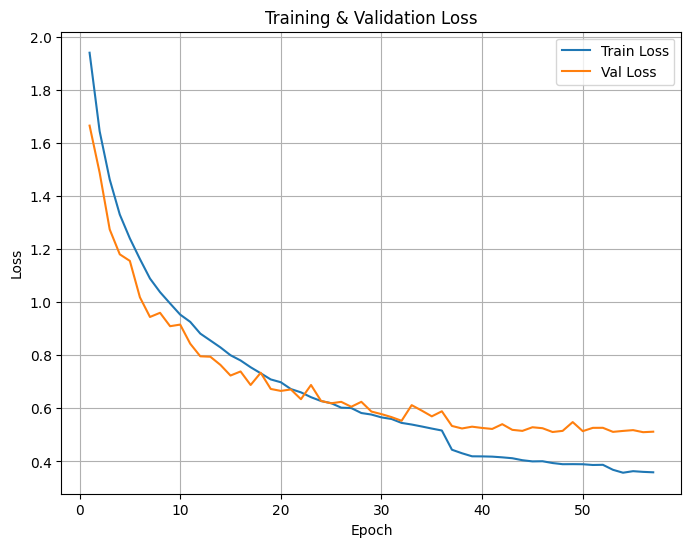

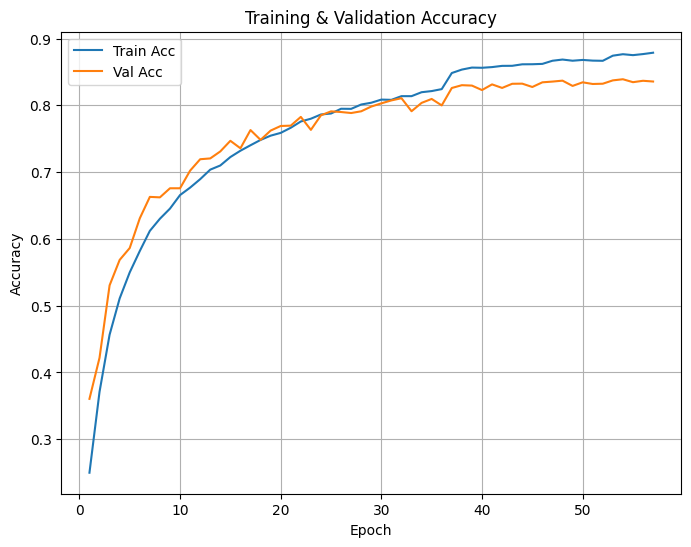

In [ ]:
train_losses = fc3_data["train_loss"]
val_losses = fc3_data["val_loss"]
train_accs = fc3_data["train_acc"]
val_accs = fc3_data["val_acc"]
plotCurves(train_losses, val_losses, train_accs, val_accs, visuals_folder3)

In [91]:
import json, statistics
path = f"{DATA_DIR}/logs/fc0.3.json"
with open(path, 'r') as file:
    data = json.load(file)
    dict1 = data.items()
    for key, value in dict1:
        if key == "val_loss":
            list1 = value

        if key == "train_loss":
            list2 = value

        val = []
        for item1, item2 in zip(list1, list2):
            val.append(item1 - item2)

    print(len(val))

std_dev = statistics.stdev(val)
print(f"Standard Deviation (sample): {std_dev}")
print(f"Mean (sample): {statistics.mean(val)}")
print(f"Min element: {min(val)}")
print(f"Max element: {max(val)}")

57
Standard Deviation (sample): 0.1038723129558377
Mean (sample): 0.020200745057850553
Min element: -0.2748126544952394
Max element: 0.15852904450893401


#### Generalization gap
Mean gap: 0.0766


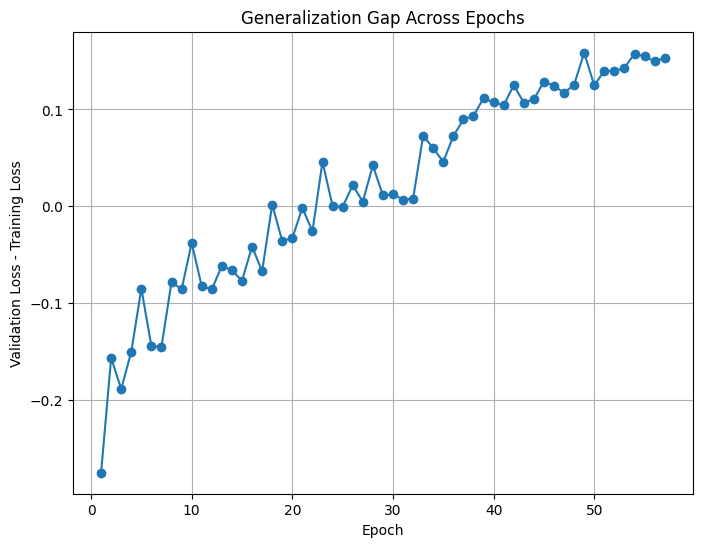

In [ ]:
genError(visuals_folder3, train_losses, val_losses)

Accuracy: 0.8168
              precision    recall  f1-score   support

           0     0.8020    0.8790    0.8387      1000
           1     0.8904    0.9260    0.9078      1000
           2     0.7455    0.7380    0.7417      1000
           3     0.6808    0.6590    0.6697      1000
           4     0.8149    0.7530    0.7827      1000
           5     0.7737    0.7350    0.7538      1000
           6     0.8140    0.8620    0.8373      1000
           7     0.8505    0.8420    0.8462      1000
           8     0.9036    0.8900    0.8967      1000
           9     0.8858    0.8840    0.8849      1000

    accuracy                         0.8168     10000
   macro avg     0.8161    0.8168    0.8160     10000
weighted avg     0.8161    0.8168    0.8160     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

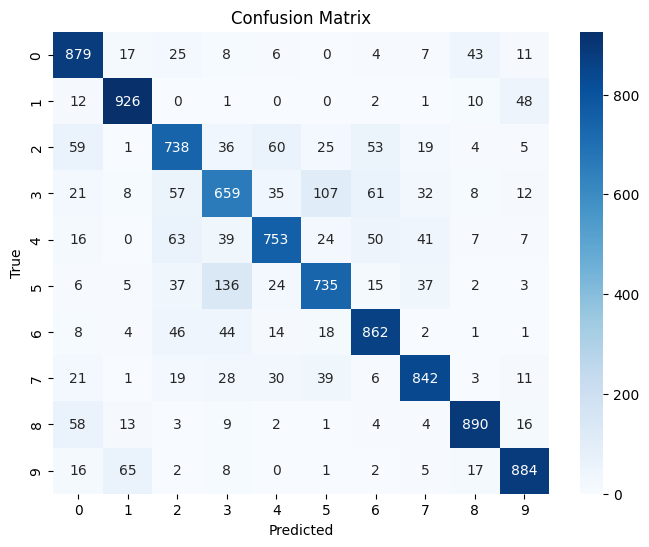

In [ ]:
evalModel(fc3model, visuals_folder3, test_loader)

### Dropout p = 0.5

In [32]:
# p = 0.5 in the model definition.
fc5_layer = [
    FCBlock(128, 64, True, 0.5),
    torch.nn.Linear(64, 10)
]

drop_5_model = MiniCNN(base_conv_layers, fc5_layer)

In [ ]:
"""
history_drop5 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.5"
path = f"{DATA_DIR}/weights"
fc5model = trainModel(drop_5_model, history_drop5, train_loader, val_loader, model_type, path, 10)
"""

In [ ]:
"""
history_path5 = f"{DATA_DIR}/logs/fc0.5.json"
saveHistory(history_drop5, history_path5) # Saves the training metadata to a json file
"""

File Saved!


In [33]:
visuals_folder5 = f"{DATA_DIR}/visualizations/fc0.5"
weights_path = f"{DATA_DIR}/weights/fc0.5.pth"
fc5model = loadWeights(drop_5_model, weights_path)

In [34]:
fc5_json = f"{DATA_DIR}/logs/fc0.5.json"
fc5_data = readJson(fc5_json)

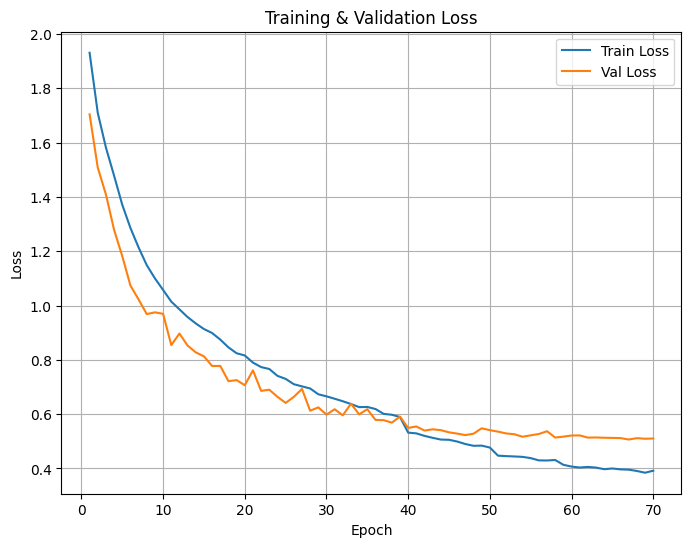

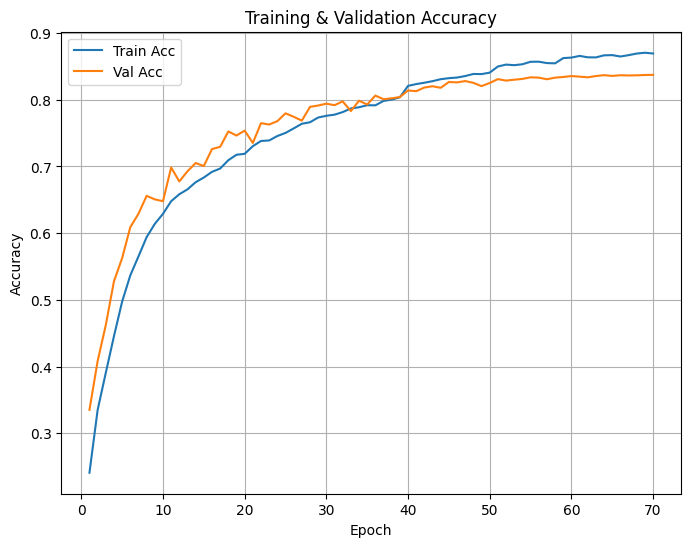

In [35]:
train_losses_fc5 = fc5_data["train_loss"]
val_losses_fc5 = fc5_data["val_loss"]
train_accs_fc5 = fc5_data["train_acc"]
val_accs_fc5 = fc5_data["val_acc"]
plotCurves(train_losses_fc5, val_losses_fc5, train_accs_fc5, val_accs_fc5, visuals_folder5)

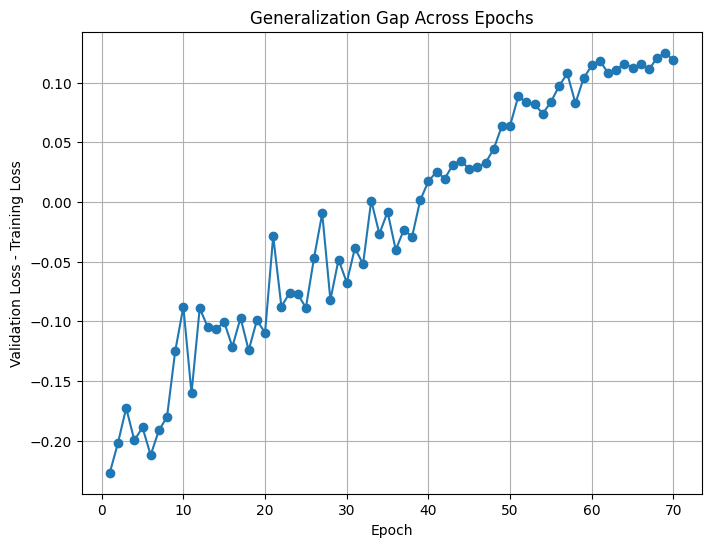

In [ ]:
genError(visuals_folder5, train_losses_fc5, val_losses_fc5)

Accuracy: 0.8381
              precision    recall  f1-score   support

           0     0.8528    0.8400    0.8463      1000
           1     0.9170    0.9500    0.9332      1000
           2     0.7747    0.7460    0.7601      1000
           3     0.7223    0.6840    0.7026      1000
           4     0.7917    0.8170    0.8041      1000
           5     0.7943    0.7570    0.7752      1000
           6     0.8305    0.8770    0.8531      1000
           7     0.8789    0.8640    0.8714      1000
           8     0.8965    0.9350    0.9153      1000
           9     0.9092    0.9110    0.9101      1000

    accuracy                         0.8381     10000
   macro avg     0.8368    0.8381    0.8372     10000
weighted avg     0.8368    0.8381    0.8372     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

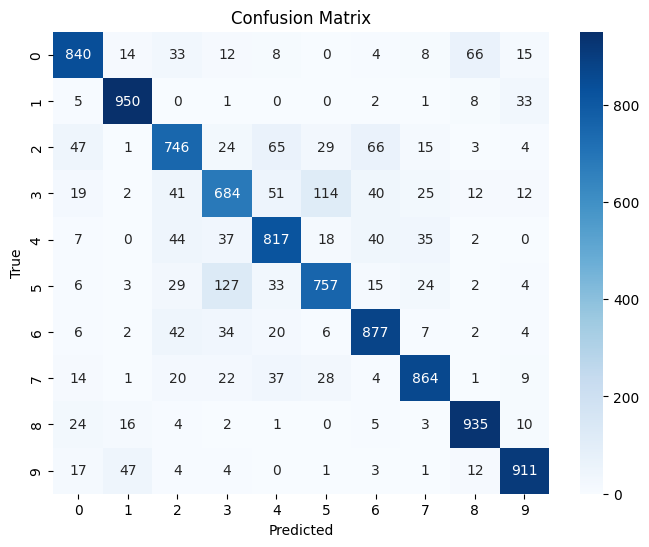

In [ ]:
evalModel(fc5model, visuals_folder5, test_loader)

In [36]:
# p = 0.7 in the model definition.
fc7_layer = [
    FCBlock(128, 64, True, 0.5),
    torch.nn.Linear(64, 10)
]

drop_7_model = MiniCNN(base_conv_layers, fc7_layer)

In [ ]:
"""
history_drop7 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.7"
path = f"{DATA_DIR}/weights"
fc7model = trainModel(drop_7_model, history_drop7, train_loader, val_loader, model_type, path, 10)
"""

In [11]:
"""
history_path7 = f"{DATA_DIR}/logs/fc0.7.json"
saveHistory(history_drop7, history_path7) # Saves the training metadata to a json file
"""

'\nhistory_path7 = f"{DATA_DIR}/logs/fc0.7.json"\nsaveHistory(history_drop7, history_path7) # Saves the training metadata to a json file\n'

In [37]:
visuals_folder7 = f"{DATA_DIR}/visualizations/fc0.7"
weights_path = f"{DATA_DIR}/weights/fc0.7.pth"
fc7model = loadWeights(drop_7_model, weights_path)

fc7_json = f"{DATA_DIR}/logs/fc0.7.json"
fc7_data = readJson(fc7_json)

Save folder not found, creating..


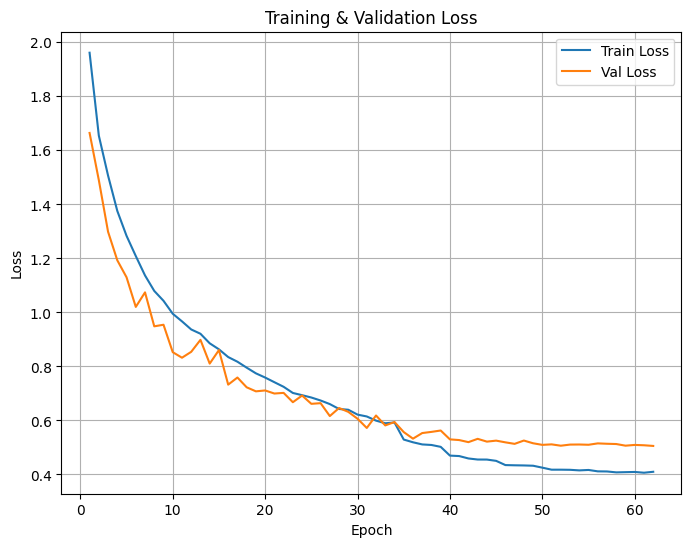

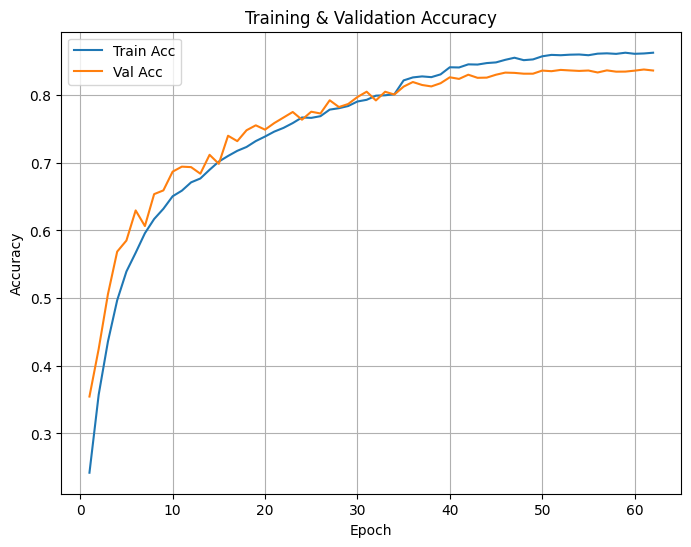

In [38]:
train_losses_fc7 = fc7_data["train_loss"]
val_losses_fc7 = fc7_data["val_loss"]
train_accs_fc7 = fc7_data["train_acc"]
val_accs_fc7 = fc7_data["val_acc"]
plotCurves(train_losses_fc7, val_losses_fc7, train_accs_fc7, val_accs_fc7, visuals_folder7)

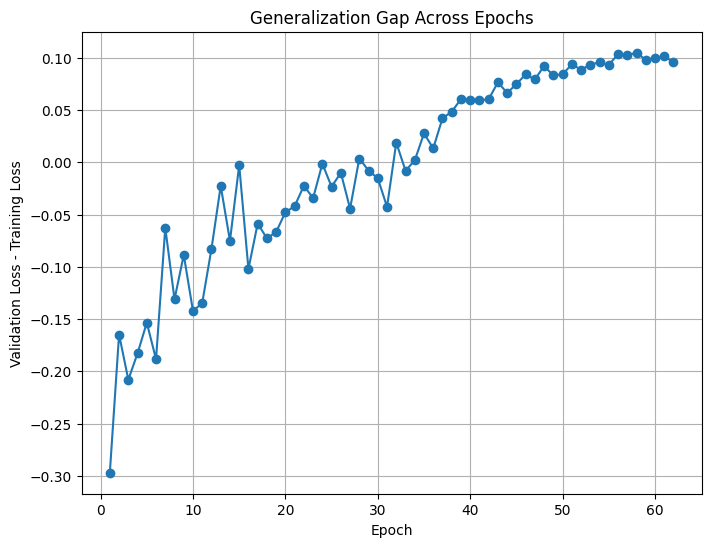

In [39]:
genError(visuals_folder7, train_losses_fc7, val_losses_fc7)

Accuracy: 0.8099
              precision    recall  f1-score   support

           0     0.8123    0.8220    0.8171      1000
           1     0.9098    0.9180    0.9139      1000
           2     0.7390    0.7220    0.7304      1000
           3     0.6649    0.6370    0.6507      1000
           4     0.8013    0.7660    0.7832      1000
           5     0.7241    0.7480    0.7359      1000
           6     0.8235    0.8490    0.8360      1000
           7     0.8471    0.8420    0.8445      1000
           8     0.8948    0.8850    0.8899      1000
           9     0.8742    0.9100    0.8917      1000

    accuracy                         0.8099     10000
   macro avg     0.8091    0.8099    0.8093     10000
weighted avg     0.8091    0.8099    0.8093     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

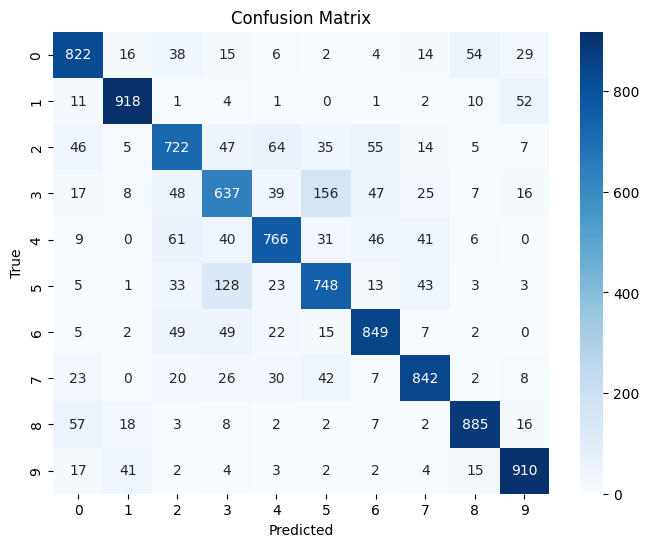

In [40]:
evalModel(fc7model, visuals_folder7, test_loader)

## Results
Validation accuracy per dropout rate:  

| Model                | Val Acc | Test Acc |  
|----------------------|---------|----------|  
| Baseline             | 82.4%   | 81.8%    |  
| FC Dropout (p=0.3)   | 83.9%   | 81.7%    |  
| FC Dropout (p=0.5)   | 83.7%   | 83.8%    |  
| FC Dropout (p=0.7)   | 83.8%   | 81.0%    |  

## Discussion
- Dropout at p=0.5 gave best performance.  
- Very high dropout (p=0.7) hurt training stability.  
- Confirms hypothesis that moderate dropout improves generalization.  

## Conclusion
Dropout in fully connected layers improved accuracy by ~2% over the baseline, with p=0.5 performing best.